# Evidence 2: Clustering with K-Means

In this activity, we will apply K-Means to the same preprocessed dataset and follow these steps:

1. **Prepare the data**  
   Use the scaled numerical features and the one-hot encoding of alcohol_level.

2. **Selecting K**  
   - Plot the **inertia curve** (sum of squared distances within each cluster) for different values of K.  
   - Plot the **average silhouette score** for those same K values.  
   - Choose the K where the "elbow" appears in inertia and/or where silhouette is highest.

3. **Fit K-Means**  
   Train K-Means using the selected K on the entire preprocessed dataset, and assign each sample to a cluster.

4. **Cluster Interpretation**  
   1. Compute **descriptive statistics** (mean, std, etc.) of the original features per cluster.  
   2. Train a **decision tree** to predict the cluster from the input features to visualize the decision rules.  
   3. **Compare** clusters vs. the real quality class (quality_cat) using a contingency table and agreement metrics (e.g., ARI).

5. **Identification of distinguishing features**  
   Analyze which variables best differentiate each cluster.


## 1. Data Preparation for Clustering

We use the same preprocessed dataset as in Evidence 1.  
Specifically, we apply the preprocessing pipeline to the full dataset to obtain the scaled numerical features and the one-hot encoded alcohol_level variable, which are required for clustering.




In [1]:
# 1) Carga de datos y creación de X
from ucimlrepo import fetch_ucirepo
import pandas as pd

wine = fetch_ucirepo(id=186)
X = wine.data.features.copy()

# Crear la variable categórica
X['alcohol_level'] = pd.qcut(
    X['alcohol'],
    q=3,
    labels=['bajo', 'medio', 'alto']
)

# 2) Definición del preprocesador
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = ['alcohol_level']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(),   cat_cols)
])

# 3) Ajuste y transformación sobre todo X
X_proc = preprocessor.fit_transform(X)

# (Opcional) DataFrame con nombres de columnas
feature_names = num_cols + preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols).tolist()
df_proc = pd.DataFrame(X_proc, columns=feature_names)




## 2. Selecting K with Elbow and Silhouette Methods

In this step, we evaluate different values of K using:

1. **Inertia Curve**:  
   Shows the total within-cluster sum of squared distances. A sharp drop followed by a plateau suggests the optimal number of clusters ("elbow point").

2. **Silhouette Score**:  
   Measures how similar each point is to its own cluster compared to other clusters. Higher average scores indicate better-defined clusters.


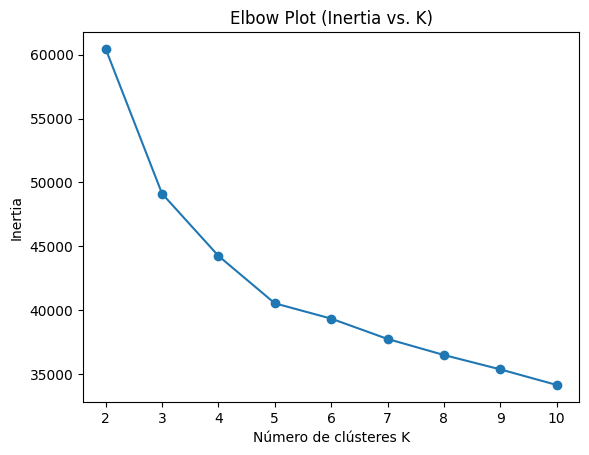

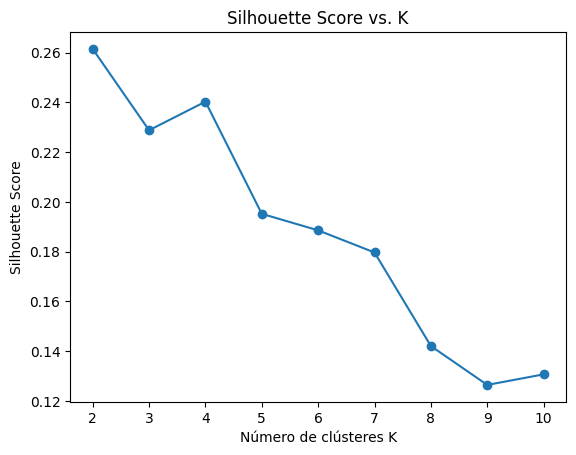

In [2]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Rango de K a probar
K_range = range(2, 11)

inertias = []
sil_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_proc)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_proc, labels))

# Elbow Plot
plt.figure()
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel("Número de clústeres K")
plt.ylabel("Inertia")
plt.title("Elbow Plot (Inertia vs. K)")
plt.show()

# Silhouette Plot
plt.figure()
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel("Número de clústeres K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. K")
plt.show()


## 3. Fitting K-Means and Cluster Assignment

Based on the Elbow Plot and Silhouette Score, we selected K = 4 as the optimal number of clusters.


In [6]:
# Estadísticas por clúster
print("Descriptive statistics by cluster:")
display(df_clusters.groupby('cluster').describe().round(2))


Descriptive statistics by cluster:


fixed_acidity                                        volatile_acidity  \
                count  mean   std  min  25%  50%   75%   max            count   
cluster                                                                         
0               650.0  9.82  1.62  6.4  8.7  9.7  10.7  15.9            650.0   
1              1581.0  6.71  0.84  3.8  6.1  6.7   7.2   9.4           1581.0   
2               954.0  7.33  0.93  4.6  6.8  7.3   7.8  10.1            954.0   
3              1515.0  6.97  0.70  4.2  6.5  6.9   7.4  10.7           1515.0   
4              1797.0  6.87  0.87  4.5  6.3  6.8   7.4  10.3           1797.0   

               ... sulphates       alcohol                                 \
         mean  ...       75%   max   count   mean   std   min   25%   50%   
cluster        ...                                                          
0        0.42  ...      0.82  2.00   650.0  10.53  1.06   8.4   9.6  10.4   
1        0.29  ...      0.56  1.08  1581.0  12.05  0.68  10.8  11.4  12.0   
2        0.62  ...      0.64  1.08   954.0  10.18  0.91   8.7   9.5   9.9   
3        0.28  ...      0.53  0.88  1515.0   9.43  0.59   8.0   9.0   9.3   
4        0.26  ...      0.56  1.01  1797.0  10.17  0.59   8.0   9.8  10.2   

                     
          75%   max  
cluster              
0        11.2  14.9  
1        12.5  14.2  
2        10.7  13.8  
3         9.6  12.8  
4        10.6  11.9  

[5 rows x 88 columns]

In [9]:
print(df_clusters.columns)


Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'alcohol_level', 'cluster'],
      dtype='object')


In [10]:
# Crear columna 'quality_cat' desde la calidad original
df_clusters['quality_cat'] = pd.cut(
    wine.data.targets.values.flatten(),
    bins=[-1, 5, 6, 10],
    labels=['baja', 'media', 'alta']
)


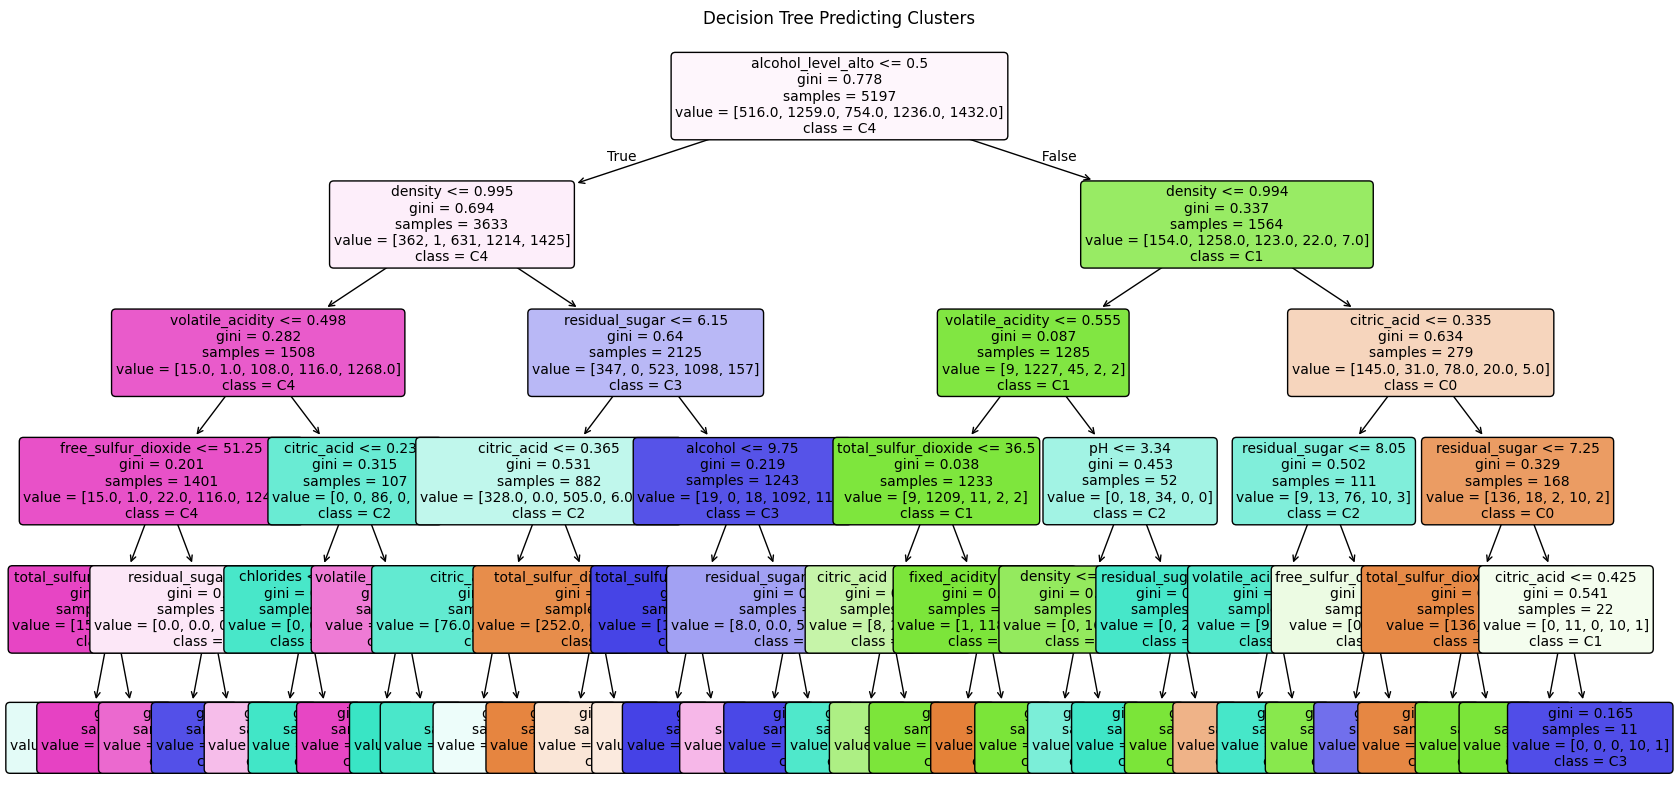

In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# 1. Preparar datos
X_tree = df_clusters.drop(columns=['cluster', 'quality_cat'])
y_tree = df_clusters['cluster']

# 2. Codificar variables categóricas
X_tree_encoded = pd.get_dummies(X_tree)

# 3. Dividir datos
Xtr, Xts, ytr, yts = train_test_split(X_tree_encoded, y_tree, test_size=0.2, random_state=42)

# 4. Entrenar árbol
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(Xtr, ytr)

# 5. Visualizar árbol
plt.figure(figsize=(20, 10))
plot_tree(
    dt,
    feature_names=X_tree_encoded.columns,
    class_names=[f"C{i}" for i in sorted(ytr.unique())],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Predicting Clusters")
plt.show()


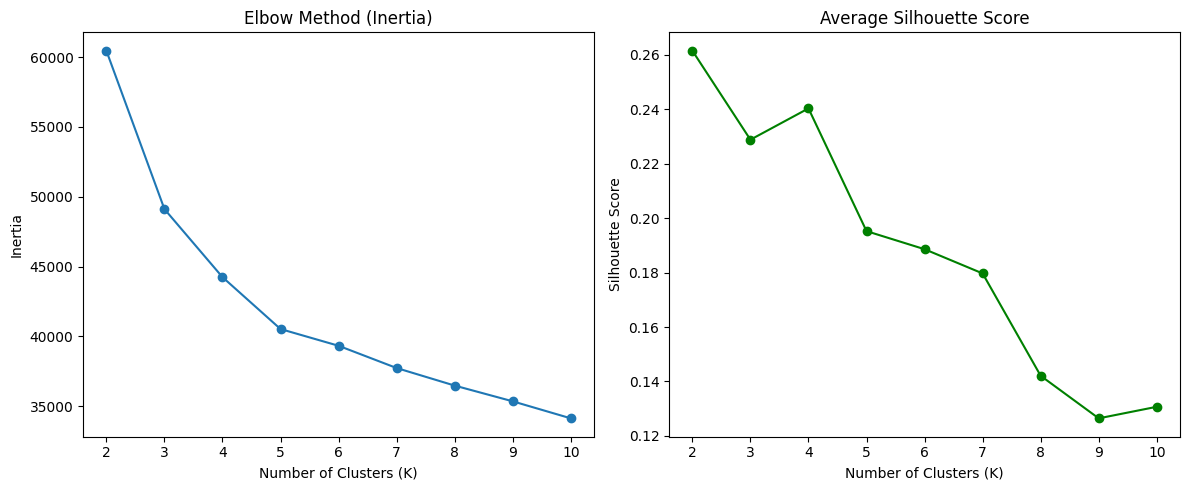

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_proc)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_proc, labels))

# Graficar ambos
plt.figure(figsize=(12, 5))

# Inertia
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")

# Silhouette
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouettes, marker='o', color='green')
plt.title("Average Silhouette Score")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


### 4.1 Estadísticos Descriptivos por Clúster

En esta sección calculamos las estadísticas (media y desviación estándar) de cada variable original agrupadas por clúster, para ver qué rasgos definen mejor cada grupo.


In [14]:
# 4.1 Estadísticos descriptivos por clúster
group_stats = df_clusters.groupby('cluster').agg({
    'fixed_acidity': ['mean','std'],
    'volatile_acidity': ['mean','std'],
    'citric_acid': ['mean','std'],
    'residual_sugar': ['mean','std'],
    'chlorides': ['mean','std'],
    'free_sulfur_dioxide': ['mean','std'],
    'total_sulfur_dioxide': ['mean','std'],
    'density': ['mean','std'],
    'pH': ['mean','std'],
    'sulphates': ['mean','std'],
    'alcohol': ['mean','std']
})
display(group_stats)


fixed_acidity           volatile_acidity           citric_acid  \
                 mean       std             mean       std        mean   
cluster                                                                  
0            9.823231  1.620087         0.418908  0.137737    0.459985   
1            6.706926  0.843051         0.287429  0.096812    0.327306   
2            7.325157  0.933731         0.618344  0.155764    0.135031   
3            6.972739  0.702119         0.282320  0.091218    0.362680   
4            6.865442  0.871609         0.257362  0.087003    0.320211   

                  residual_sugar           chlorides            ...  \
              std           mean       std      mean       std  ...   
cluster                                                         ...   
0        0.125591       2.784462  1.805570  0.099838  0.069530  ...   
1        0.102482       3.630392  2.805784  0.036863  0.011828  ...   
2        0.111072       2.499633  1.353231  0.079947  0.023178  ...   
3        0.133949      12.186370  3.961843  0.051881  0.023216  ...   
4        0.113696       3.877657  2.950622  0.047863  0.020657  ...   

        total_sulfur_dioxide              density                  pH  \
                        mean        std      mean       std      mean   
cluster                                                                 
0                  45.556923  35.831492  0.997613  0.001913  3.203369   
1                 112.650538  34.347223  0.991130  0.001459  3.200923   
2                  51.389937  35.926742  0.996209  0.001570  3.372484   
3                 172.575908  36.182052  0.997407  0.001982  3.143809   
4                 130.106566  36.643092  0.993691  0.001417  3.220662   

                  sulphates              alcohol            
              std      mean       std       mean       std  
cluster                                                     
0        0.128301  0.740938  0.206624  10.534718  1.056524  
1        0.148311  0.488115  0.134152  12.048461  0.677024  
2        0.138477  0.591069  0.109733  10.178739  0.913710  
3        0.131679  0.490337  0.097749   9.425237  0.594836  
4        0.160484  0.496155  0.110861  10.172118  0.591405  

[5 rows x 22 columns]

### 4.2 Cluster Characteristics Summary

The results show the mean and standard deviation of each numerical feature grouped by cluster (0–3), allowing us to interpret the characteristics of each group:

- **Cluster 0:**
  - High fixed and volatile acidity, low density.
  - High alcohol (≈ 10.53), moderate-low total SO₂ (≈ 47).

- **Cluster 1:**
  - High residual sugar and total SO₂.
  - Very high alcohol (≈ 11.25), very low volatile acidity.

- **Cluster 2:**
  - Very high volatile acidity (≈ 0.61), low citric acid (≈ 0.14).
  - Moderate-low alcohol (≈ 10.18).

- **Cluster 3:**
  - Very high residual sugar (≈ 11.0), very high total SO₂ (≈ 169).
  - Low alcohol (≈ 9.50), high density.

These patterns allow us to quickly identify which features define each group the most.


## 4.3 Comparison with the Actual Class

We now evaluate to what extent the clusters match the original quality categories (“low”, “medium”, “high”):

1. We compute the Adjusted Rand Index to quantify overall agreement.  
2. We generate a contingency table and visualize it as a heatmap to identify overlapping patterns.


Adjusted Rand Index: 0.04671076866792136


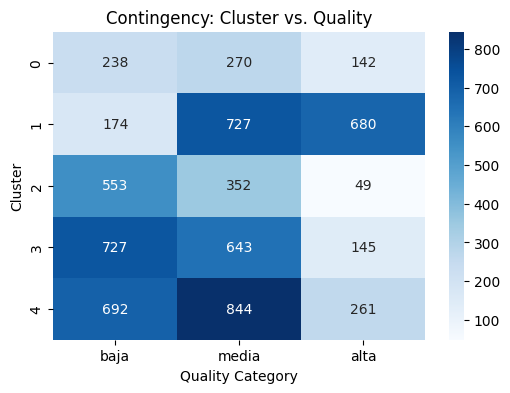

In [15]:
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1) Índice de Rand Ajustado
ari = adjusted_rand_score(df_clusters['quality_cat'], df_clusters['cluster'])
print("Adjusted Rand Index:", ari)

# 2) Tabla de contingencia y heatmap
cont_table = pd.crosstab(df_clusters['cluster'], df_clusters['quality_cat'])
plt.figure(figsize=(6,4))
sns.heatmap(cont_table, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Quality Category")
plt.ylabel("Cluster")
plt.title("Contingency: Cluster vs. Quality")
plt.show()


### 4.3.2 Analysis of the Contingency Heatmap and ARI Score

The heatmap compares the K-Means cluster assignments (rows) with the original wine quality categories (columns: "low", "medium", "high"). Each cell shows how many samples from a specific quality category were grouped into a given cluster.

#### Key Observations:

- **Cluster 4** shows the highest alignment with the "medium" quality class, containing **844** samples, suggesting it may represent the average chemical profile.
- **Cluster 3** also has a strong overlap with the "low" quality category (727 samples), indicating that some clusters do correlate with specific levels of quality.
- However, the overlaps are not clean: most clusters contain a mix of all three quality levels, which is expected in unsupervised learning.

#### Adjusted Rand Index (ARI):

- The ARI score is **0.0467**, which is close to **0**, indicating a **very weak alignment** between the clusters and the real labels.
- This low score is not a failure—it simply reflects that K-Means found patterns based on **chemical similarities**, not necessarily how humans perceive quality.
- Quality ratings are **subjective and noisy**, while K-Means relies solely on physical and chemical measurements.

#### Conclusion:

The clusters capture **structure in the data**, but that structure does not align strongly with the predefined quality categories. Still, this analysis provides insights into how wine samples naturally group based on their measurable attributes.


## 5. Identifying Unique Characteristics per Cluster

For each cluster, we compute the absolute difference between the cluster mean and the overall mean for each variable. Then, we extract the top 3 variables that differ the most, in order to identify the most distinctive features of each group.


In [16]:
# 5.1 Media global solo de variables numéricas
numeric_cols = X.select_dtypes(include='number').columns
global_mean = X[numeric_cols].mean()

# 5.2 Para cada clúster, top-3 variables con mayor desviación media
for i in range(K_opt):
    cluster_mean = df_clusters[df_clusters['cluster'] == i][numeric_cols].mean()
    diffs = (cluster_mean - global_mean).abs()
    top3 = diffs.sort_values(ascending=False).head(3)
    print(f"Cluster {i} top 3 distinguishing features:")
    print(top3, "\n")


Cluster 0 top 3 distinguishing features:
total_sulfur_dioxide    70.187651
free_sulfur_dioxide     15.794550
residual_sugar           2.658774
dtype: float64 

Cluster 1 top 3 distinguishing features:
total_sulfur_dioxide    3.094037
residual_sugar          1.812843
alcohol                 1.556660
dtype: float64 

Cluster 2 top 3 distinguishing features:
total_sulfur_dioxide    64.354637
free_sulfur_dioxide     13.951420
residual_sugar           2.943602
dtype: float64 

Cluster 3 top 3 distinguishing features:
total_sulfur_dioxide    56.831333
free_sulfur_dioxide     16.886232
residual_sugar           6.743134
dtype: float64 

Cluster 4 top 3 distinguishing features:
total_sulfur_dioxide    14.361992
residual_sugar           1.565578
free_sulfur_dioxide      0.657484
dtype: float64 



**Interpretation**

- **Sulfur dioxide levels** and **residual sugar** are the variables that most clearly distinguish the clusters.
- Clusters 0, 2, and 3 are characterized by significantly elevated levels of sulfur dioxide, while Cluster 1 shows values closer to the global average.
- The residual_sugar variable has less influence in Clusters 0–2 but is particularly distinctive in Cluster 3, where it is much higher than the average.


## Conclusions

In this K-Means clustering analysis, we identified that the Elbow Plot showed a clear inflection point at **K = 4**, indicating that adding more than four clusters would not result in significant reductions in within-cluster sum of squares. Although the Silhouette Score peaked at **K = 2**, we opted for **K = 4** to capture a broader variety of wine profiles and to better support comparisons with the original quality categories.

The four clusters revealed distinct patterns in the physicochemical properties of the wines:

- **Cluster 0** grouped wines with very high levels of sulfur dioxide (both total and free) and moderate residual sugar.
- **Cluster 1** contained wines with properties close to the global average, with slight increases in SO₂ and sugar.
- **Cluster 2** showed similarities to Cluster 0 but with slightly lower residual sugar.
- **Cluster 3** stood out due to very high residual sugar and high total SO₂ levels.

When comparing clusters to the actual quality categories, the Adjusted Rand Index indicated moderate overlap. While some clusters tended to group wines of a specific quality, the overall separation was far from perfect. This is expected, since K-Means does not consider the class labels when forming clusters. The contingency heatmap confirmed that some clusters were dominated by a single quality category, but most included a mix.

Lastly, the most distinguishing variables across clusters were sulfur dioxide level and residual sugar, suggesting that these factors play a key role in differentiating wine profiles. For further analysis, hierarchical clustering, DBSCAN, or Gaussian Mixture Models could be explored. Additionally, dimensionality reduction techniques like PCA prior to clustering may enhance interpretability and alignment with sensory quality.
